**Persiapan**

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

**Mengunduh Dataset**

In [ ]:
! chmod 600 /content/kaggle.json

In [ ]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d dedeikhsandwisaputra/rice-leafs-disease-dataset

 92% 272M/294M [00:01<00:00, 155MB/s]
100% 294M/294M [00:01<00:00, 189MB/s]


In [ ]:
#Mengekstrak gambar
zip_file = zipfile.ZipFile('/content/rice-leafs-disease-dataset.zip')
zip_file.extractall('/content/rice-leafs-disease-dataset')

In [ ]:
base_dir = '/content/rice-leafs-disease-dataset'
folder_train = '/content/rice-leafs-disease-dataset/RiceLeafsDisease/train'
folder_validation = '/content/rice-leafs-disease-dataset/RiceLeafsDisease/validation'

In [ ]:
print(os.listdir(folder_train))
print(os.listdir(folder_validation))

['bacterial_leaf_blight', 'healthy', 'leaf_blast', 'brown_spot', 'narrow_brown_spot', 'leaf_scald']
['bacterial_leaf_blight', 'healthy', 'leaf_blast', 'brown_spot', 'narrow_brown_spot', 'leaf_scald']


In [ ]:
#Menghitung Jumlah pada Dataset
total_data = 0

# Iterasi semua file di dalam direktori
for root, dirs, files in os.walk(base_dir):
    total_data += len(files)

print("Jumlah total data:", total_data)

Jumlah total data: 2628


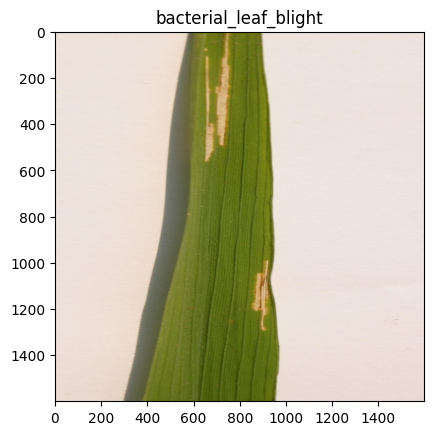

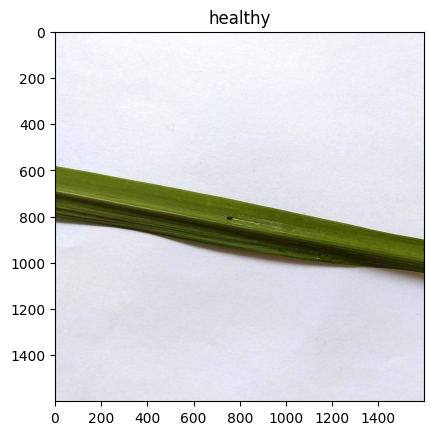

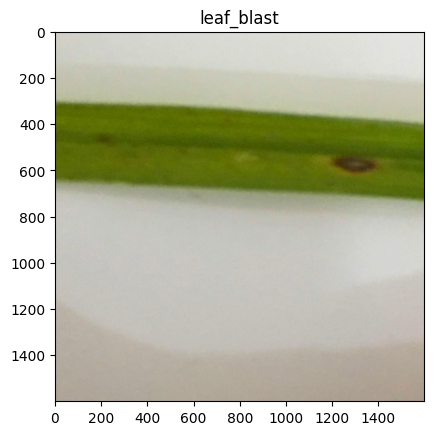

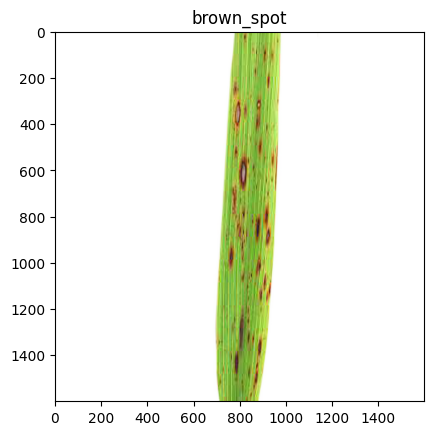

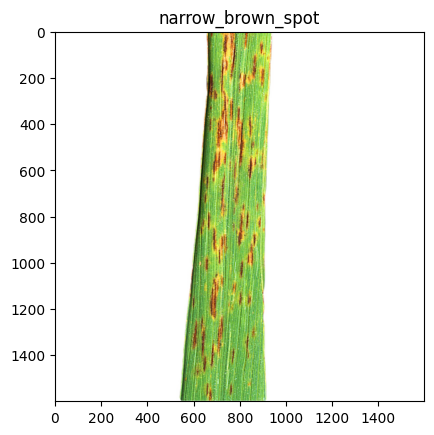

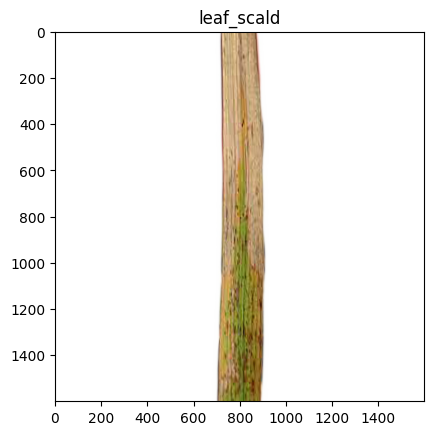

In [ ]:
#Menampilkan gambar tiap kelas
for root, dirs, files in os.walk(folder_train):
    for dir_name in dirs:
        folder_path = os.path.join(root, dir_name)
        image_files = os.listdir(folder_path)
        if len(image_files) > 0:
            image_path = os.path.join(folder_path, image_files[0])
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.title(dir_name)
            plt.show()

**DATA PREPARATION**

In [ ]:
IMAGE_SIZE = (250,250)
BATCH_SIZE = 32
SEED = 999

In [ ]:
# Menggunakan ImageDataGenerator untuk preprocessing
imagegenerator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

In [ ]:
# Image Data Generator pada Dataset
train_data = imagegenerator.flow_from_directory(
    folder_train,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

validation_data = imagegenerator.flow_from_directory(
    folder_validation,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 2100 images belonging to 6 classes.
Found 528 images belonging to 6 classes.


In [ ]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

**MODEL**

Penyusunan Layer

In [ ]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
#Melatih Model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data = validation_data
)

Epoch 1/20
66/66 [==============================] - 91s 1s/step - loss: 1.5469 - accuracy: 0.3695 - val_loss: 1.2515 - val_accuracy: 0.4792
Epoch 2/20
66/66 [==============================] - 75s 1s/step - loss: 1.0117 - accuracy: 0.6224 - val_loss: 0.9108 - val_accuracy: 0.6591
Epoch 3/20
66/66 [==============================] - 75s 1s/step - loss: 0.8405 - accuracy: 0.6857 - val_loss: 0.7277 - val_accuracy: 0.7254
Epoch 4/20
66/66 [==============================] - 76s 1s/step - loss: 0.7641 - accuracy: 0.7190 - val_loss: 0.8355 - val_accuracy: 0.7102
Epoch 5/20
66/66 [==============================] - 81s 1s/step - loss: 0.6538 - accuracy: 0.7538 - val_loss: 0.6047 - val_accuracy: 0.7746
Epoch 6/20
66/66 [==============================] - 76s 1s/step - loss: 0.6113 - accuracy: 0.7752 - val_loss: 0.5785 - val_accuracy: 0.7727
Epoch 7/20
66/66 [==============================] - 77s 1s/step - loss: 0.5472 - accuracy: 0.7929 - val_loss: 0.5198 - val_accuracy: 0.8030
Epoch 8/20
66/66 [==

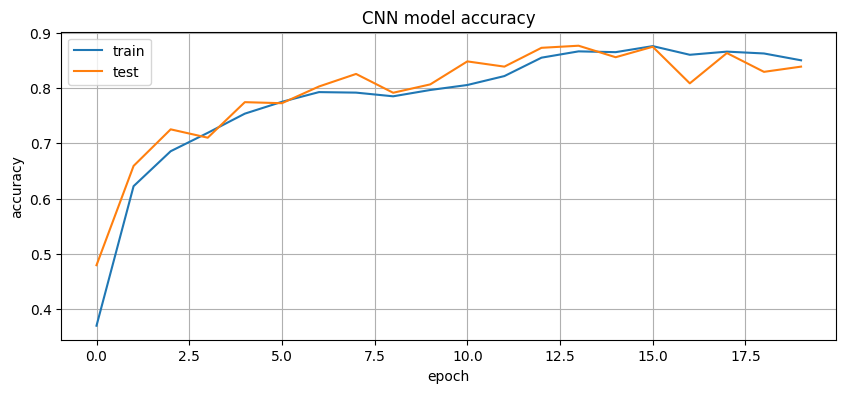

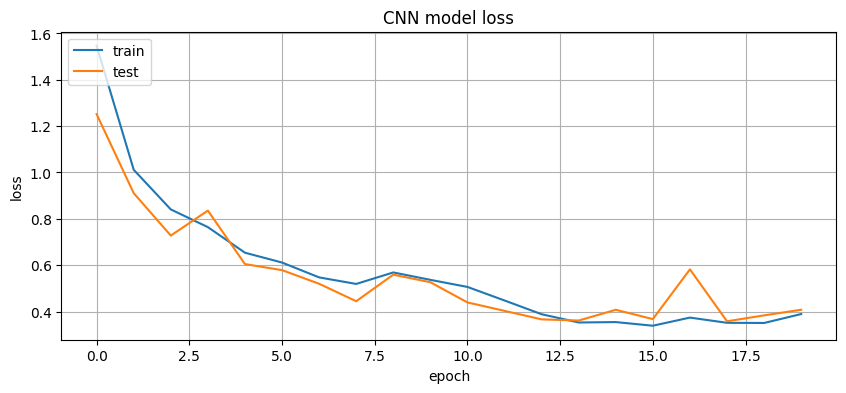

In [ ]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Transfer Learning VGG16**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=20,
    validation_data = validation_data
)

Epoch 1/20
66/66 [==============================] - 94s 1s/step - loss: 1.3078 - accuracy: 0.4781 - val_loss: 0.8516 - val_accuracy: 0.6799
Epoch 2/20
66/66 [==============================] - 79s 1s/step - loss: 0.9040 - accuracy: 0.6400 - val_loss: 0.8163 - val_accuracy: 0.6572
Epoch 3/20
66/66 [==============================] - 81s 1s/step - loss: 0.8199 - accuracy: 0.6767 - val_loss: 0.6469 - val_accuracy: 0.7595
Epoch 4/20
66/66 [==============================] - 76s 1s/step - loss: 0.7257 - accuracy: 0.7152 - val_loss: 0.6770 - val_accuracy: 0.7576
Epoch 5/20
66/66 [==============================] - 77s 1s/step - loss: 0.7223 - accuracy: 0.7133 - val_loss: 0.5288 - val_accuracy: 0.8049
Epoch 6/20
66/66 [==============================] - 82s 1s/step - loss: 0.6524 - accuracy: 0.7314 - val_loss: 0.5621 - val_accuracy: 0.7860
Epoch 7/20
66/66 [==============================] - 77s 1s/step - loss: 0.5842 - accuracy: 0.7667 - val_loss: 0.5787 - val_accuracy: 0.7955
Epoch 8/20
66/66 [==

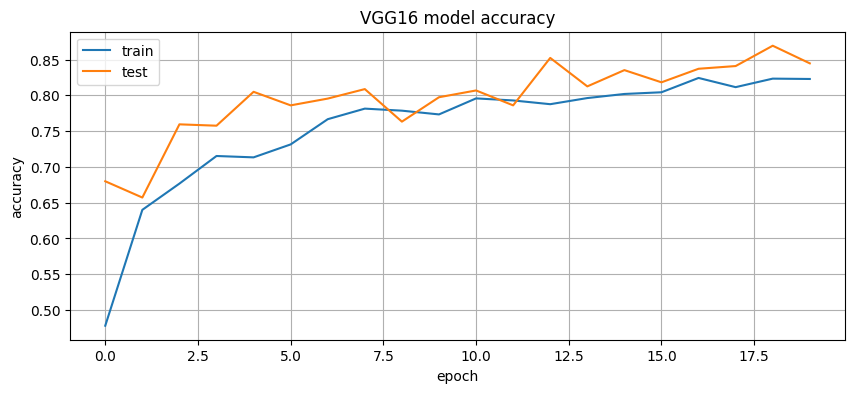

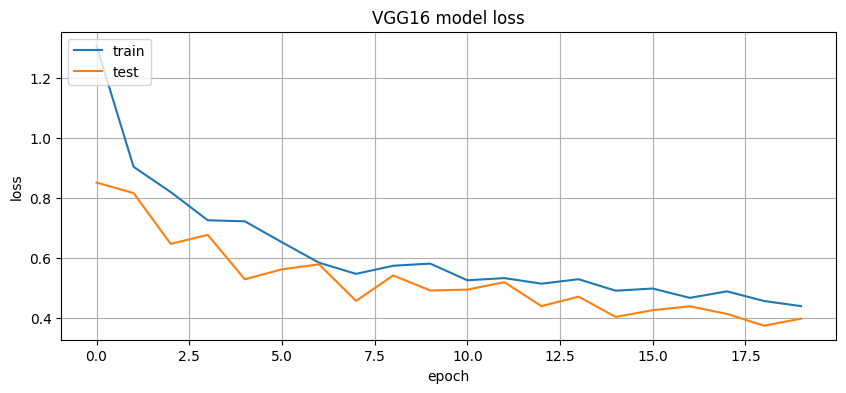

In [ ]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Transfer Learning ResNet50**

In [ ]:

from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax")
])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=20,
    validation_data = validation_data
)

Epoch 1/20
66/66 [==============================] - 94s 1s/step - loss: 1.7830 - accuracy: 0.2481 - val_loss: 1.6856 - val_accuracy: 0.3826
Epoch 2/20
66/66 [==============================] - 79s 1s/step - loss: 1.6442 - accuracy: 0.2933 - val_loss: 1.5340 - val_accuracy: 0.3920
Epoch 3/20
66/66 [==============================] - 80s 1s/step - loss: 1.5601 - accuracy: 0.3390 - val_loss: 1.4070 - val_accuracy: 0.4697
Epoch 4/20
66/66 [==============================] - 85s 1s/step - loss: 1.5153 - accuracy: 0.3790 - val_loss: 1.4674 - val_accuracy: 0.3409
Epoch 5/20
66/66 [==============================] - 80s 1s/step - loss: 1.4591 - accuracy: 0.3914 - val_loss: 1.4052 - val_accuracy: 0.3958
Epoch 6/20
66/66 [==============================] - 84s 1s/step - loss: 1.4239 - accuracy: 0.4062 - val_loss: 1.3827 - val_accuracy: 0.4299
Epoch 7/20
66/66 [==============================] - 78s 1s/step - loss: 1.3948 - accuracy: 0.4448 - val_loss: 1.4738 - val_accuracy: 0.3883
Epoch 8/20
66/66 [==

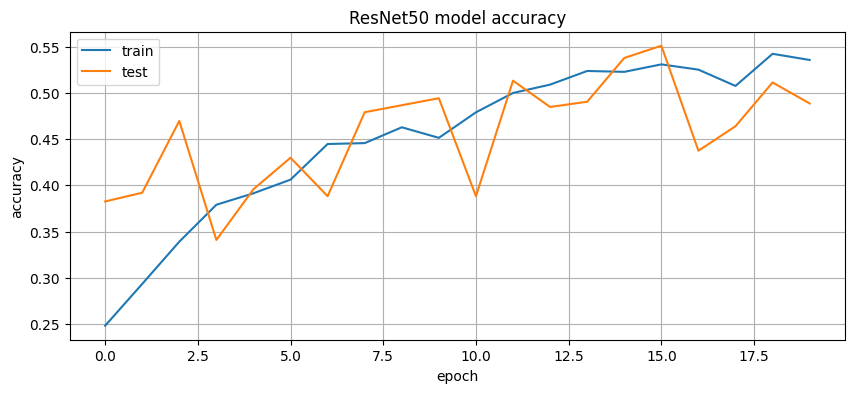

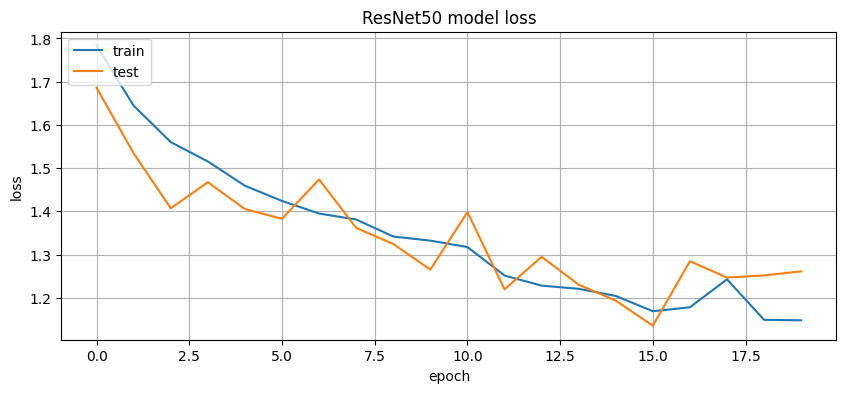

In [ ]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Transfer Learning DenseNet201**

In [ ]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=20,
    validation_data = validation_data
)

Epoch 1/20
66/66 [==============================] - 108s 1s/step - loss: 0.9643 - accuracy: 0.6471 - val_loss: 0.6694 - val_accuracy: 0.7424
Epoch 2/20
66/66 [==============================] - 77s 1s/step - loss: 0.5462 - accuracy: 0.7981 - val_loss: 0.4122 - val_accuracy: 0.8542
Epoch 3/20
66/66 [==============================] - 77s 1s/step - loss: 0.4199 - accuracy: 0.8348 - val_loss: 0.3346 - val_accuracy: 0.8750
Epoch 4/20
66/66 [==============================] - 77s 1s/step - loss: 0.3488 - accuracy: 0.8662 - val_loss: 0.3661 - val_accuracy: 0.8580
Epoch 5/20
66/66 [==============================] - 76s 1s/step - loss: 0.3123 - accuracy: 0.8814 - val_loss: 0.2655 - val_accuracy: 0.9091
Epoch 6/20
66/66 [==============================] - 77s 1s/step - loss: 0.3011 - accuracy: 0.8871 - val_loss: 0.2739 - val_accuracy: 0.9091
Epoch 7/20
66/66 [==============================] - 77s 1s/step - loss: 0.2932 - accuracy: 0.8895 - val_loss: 0.3074 - val_accuracy: 0.8693
Epoch 8/20
66/66 [=

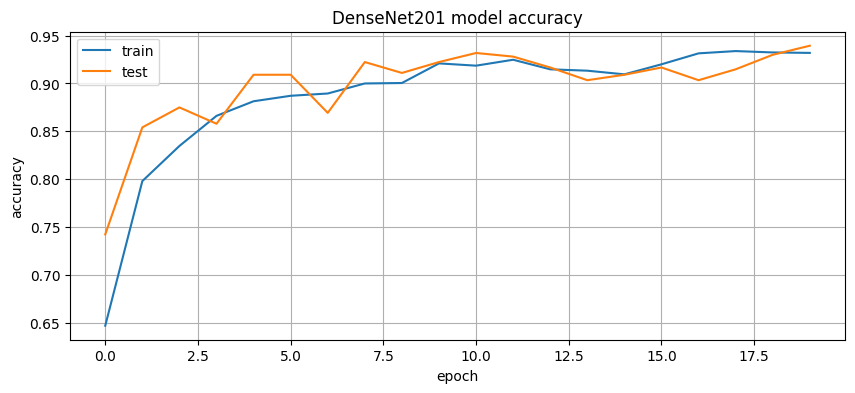

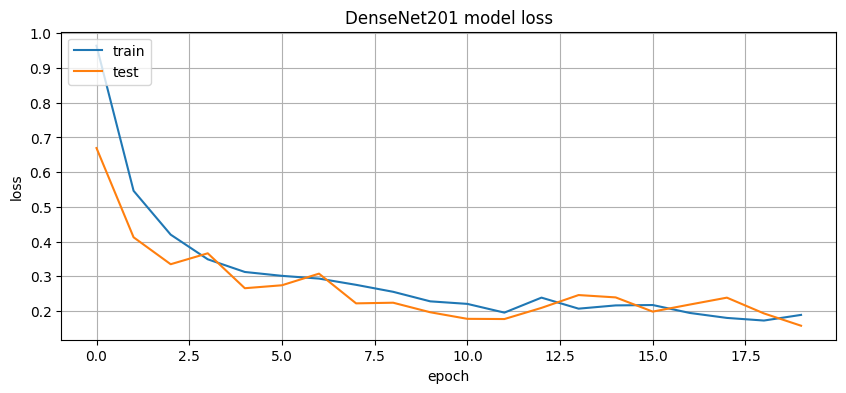

In [ ]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Evaluasi**

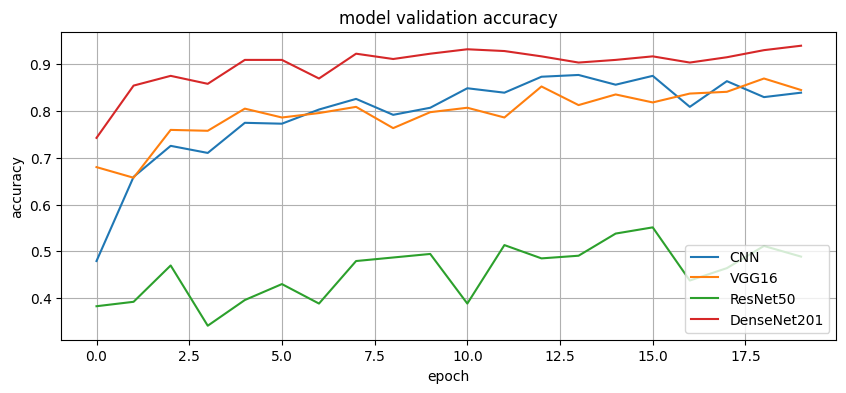

In [ ]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()

**Uji Coba**

In [ ]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

{'bacterial_leaf_blight': 0,
 'brown_spot': 1,
 'healthy': 2,
 'leaf_blast': 3,
 'leaf_scald': 4,
 'narrow_brown_spot': 5}

Saving Tulang-Daun-Sejajar.jpg to Tulang-Daun-Sejajar.jpg
1/1 [==============================] - 0s 42ms/step
Tulang-Daun-Sejajar.jpg
Bacterial Leaf Blight


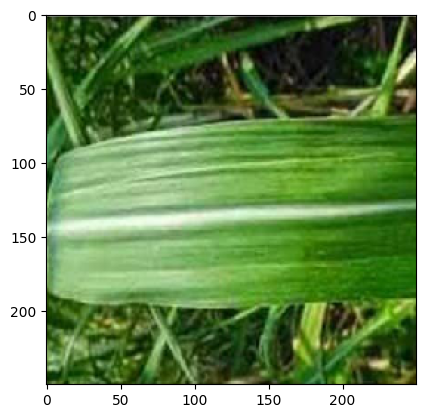

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  # Memprediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes == 0:
    print('Bacterial Leaf Blight')
  elif classes == 1:
    print('Brown Spot')
  elif classes == 2:
    print('Healthy')
  elif classes == 3:
    print('Leaf Blast')
  elif classes == 4:
    print('Leaf Scald')   
  else:
    print('Narrow Brown Spot')


**Deployment**

HDF5

In [ ]:
densenet_model.save('model-rice-diseases.h5')

TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model-rice-diseases.tflite', 'wb') as f:
  f.write(tflite_model)

TensorflowJs

In [ ]:
# Instal TensorflowJS
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/model-diseases.h5 /content/modeltfjs

2023-05-23 09:38:39.969225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 827, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 831, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 817, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 500, in _dispatch_converter
    dispatch_keras_h5_to_tfjs_layers_model_conversion(
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 76, in di